In [19]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse_sklearn
from sklearn.metrics import mean_absolute_error as mae_sklearn

In [20]:
use_GPU = torch.cuda.is_available()
if use_GPU:
    mode = {"name": "cuda", "device": torch.device("cuda")}
else:
    mode = {"name": "cpu", "device": torch.device("cpu")}

in_dim = 1
hidden_dim = 64
out_dim = 1
sequence_length = 6
batch_size = 256 # 32, 64, 128, 256

num_epochs=20
num_workers=11
lr = 1e-3
regularization=1e-6

In [21]:
# Get raw data
def get_raw_data(path):
    df = pd.read_excel(path, index_col='Datetime')
    #print(df.head(3))
    return df

In [22]:
# Load data
path = '../data/clean_data/univariate_Q_Kallveit.csv'
if os.path.isfile(path):
    data = pd.read_csv(path, index_col='Datetime')
else:
    raw_data = get_raw_data('../data/raw_data/cascaded_use_case_data.xlsx')
    # saving the dataframe
    data = raw_data[['Q_Kalltveit']].astype(np.float32)
    data.to_csv(r'../data/clean_data/univariate_Q_Kallveit.csv')
data

,Q_Kalltveit
Datetime,
2015-01-01 00:00:00,3.37060
2015-01-01 01:00:00,3.45242
2015-01-01 02:00:00,3.56260
2015-01-01 03:00:00,3.74423
2015-01-01 04:00:00,4.02901
...,...
2022-03-21 19:00:00,2.43457
2022-03-21 20:00:00,2.42514
2022-03-21 21:00:00,2.41576


In [23]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [24]:
#sc = MinMaxScaler()
#training_data = sc.fit_transform(data)
X, y = sliding_windows(data.values, sequence_length)
X.shape, y.shape

((63281, 6, 1), (63281, 1))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape)
X_train, X_val, X_test = X_train.reshape(len(X_train), -1), X_val.reshape(len(X_val), -1), X_test.reshape(len(X_test), -1)
print(X_train.shape, X_val.shape, X_test.shape)

(44296, 6, 1) (13289, 6, 1) (5696, 6, 1)
(44296, 6) (13289, 6) (5696, 6)


In [26]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

In [27]:
from torch.utils.data import Dataset
import torch

class data_trans(Dataset):
        
    def __init__(self, data, groundtruth, transform=None):

        self.data = self._get_data(data)
        self.groundtruth = self._get_data(groundtruth)
        self.transform = transform

    def _get_data(self,data):
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
               
        inputs = self.data[index,:]
        groundtruths = self.groundtruth[index,:]
        
        if self.transform:
                        
            inputs = torch.from_numpy(inputs).float()
            groundtruths = torch.from_numpy(groundtruths).float()
                       
        return [inputs, groundtruths]

In [28]:
train_data_trans = data_trans(X_train, y_train, transform)
val_data_trans = data_trans(X_val, y_val, transform)
test_data_trans = data_trans(X_test, y_test, transform)

In [29]:
train_dataloader = torch.utils.data.DataLoader(train_data_trans,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)

In [30]:
data_loader = {
    "train": train_dataloader,
    "val": val_dataloader,
    "test": test_dataloader,
}

In [31]:
class FCN(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):

        super(FCN, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.layer_in = nn.Linear(sequence_length, hidden_dim, bias=False)
        self.fcn = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, out_dim, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self,input):
        out = self.layer_in(input)
        out = self.sigmoid(out)
        out = self.fcn(out)
        out = self.sigmoid(out)
        out = self.layer_out(out)
      
        return out

In [32]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length
        
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*sequence_length, out_dim)

        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        out = self.linear_out(outputs)
        return out

In [33]:
class LSTM2(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM2, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)

        self.T_A = nn.Linear(sequence_length*hidden_dim, sequence_length)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, out_dim)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        total_ht = outputs[0]
        for i in range(1, len(outputs)):
            total_ht = torch.cat((total_ht, outputs[i]), 1)

        beta_t =  self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)

        out = torch.zeros(y.size(0), self.hidden_dim)

        for i in range(len(outputs)):
                      
            out = out + outputs[i]*beta_t[:,i].reshape(out.size(0), 1)

        out = self.linear_out(out)
        
        return out

In [34]:
from tqdm import tqdm
from torchmetrics.functional import mean_absolute_error

def fit(model, loss_function, optimizer, data_loader, num_epochs, mode, use_amp=False):
	history = {"train": {"loss": [], "mae": []}, "val": {"loss": [], "mae": []}}
	scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # Mixed-precision support for compatible GPUs
	print("\nTraining the model:")
	for epoch in range(num_epochs):
		
		print("\nEpoch", epoch+1)
		if epoch < num_epochs - 1:
			keys = ["train", "val"]
		else:
			keys = ["train", "val", "test"]
		for key in keys:
			dataset_size = 0
			dataset_loss = 0.0
			dataset_mae = 0.0
			if key == "train":
				model.train()
			else:
				model.eval()
			for X_batch, y_batch in tqdm(data_loader[key]):
				X_batch, y_batch = X_batch.to(mode["device"]), y_batch.to(mode["device"])
				with torch.set_grad_enabled(mode=(key=="train")): # Autograd activated only during training
					with torch.cuda.amp.autocast(enabled=use_amp): # Mixed-precision support for compatible GPUs
						batch_output = model(X_batch.float())
						batch_loss = loss_function(batch_output, y_batch)
					if key == "train":
						scaler.scale(batch_loss).backward()
						scaler.step(optimizer) 	
						scaler.update()
						optimizer.zero_grad()
				dataset_size += y_batch.shape[0]
				dataset_loss += y_batch.shape[0] * batch_loss.item()
				dataset_mae += mean_absolute_error(batch_output, y_batch).item()
			dataset_loss /= dataset_size
			dataset_mae /= dataset_size
			if key in ["train", "val"]:
				history[key]["loss"].append(dataset_loss)
				history[key]["mae"].append(dataset_mae)
			else:
				print("\nEvaluating the model:")
			print(key, "loss:", dataset_loss, "    ", key, "mae:", dataset_mae)
	return history


In [35]:
model_1 = FCN(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_1.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])

history = fit(model=model_1, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 174/174 [00:01<00:00, 148.97it/s]


train loss: 65.84880833938404      train mae: 0.016114434783416082


100%|██████████| 52/52 [00:00<00:00, 262.07it/s]


val loss: 49.72730942401833      val mae: 0.014662756362073676

Epoch 2


100%|██████████| 174/174 [00:01<00:00, 157.44it/s]


train loss: 44.38147062062141      train mae: 0.011009453034409552


100%|██████████| 52/52 [00:00<00:00, 202.98it/s]


val loss: 29.826887330986306      val mae: 0.008392136742742348

Epoch 3


100%|██████████| 174/174 [00:00<00:00, 180.43it/s]


train loss: 29.35269286530555      train mae: 0.005815507843754062


100%|██████████| 52/52 [00:00<00:00, 260.21it/s]


val loss: 17.736789945764325      val mae: 0.004223841058946874

Epoch 4


100%|██████████| 174/174 [00:00<00:00, 197.69it/s]


train loss: 21.677657975301386      train mae: 0.003671657666093028


100%|██████████| 52/52 [00:00<00:00, 255.75it/s]


val loss: 11.564254050699446      val mae: 0.0034143415882603757

Epoch 5


100%|██████████| 174/174 [00:00<00:00, 179.26it/s]


train loss: 17.326345717089367      train mae: 0.0031254599615998793


100%|██████████| 52/52 [00:00<00:00, 163.88it/s]


val loss: 8.088498098084594      val mae: 0.002926279578420448

Epoch 6


100%|██████████| 174/174 [00:00<00:00, 199.19it/s]


train loss: 14.39193572552398      train mae: 0.0028878267930478466


100%|██████████| 52/52 [00:00<00:00, 270.16it/s]


val loss: 5.67608109920986      val mae: 0.002537497392657182

Epoch 7


100%|██████████| 174/174 [00:00<00:00, 188.02it/s]


train loss: 12.273246693034153      train mae: 0.002821757755695923


100%|██████████| 52/52 [00:00<00:00, 244.19it/s]


val loss: 4.252160384809808      val mae: 0.002574565140107871

Epoch 8


100%|██████████| 174/174 [00:00<00:00, 199.86it/s]


train loss: 10.569521231456033      train mae: 0.002608979830990334


100%|██████████| 52/52 [00:00<00:00, 255.14it/s]


val loss: 3.0436939005871393      val mae: 0.0020539006409638623

Epoch 9


100%|██████████| 174/174 [00:00<00:00, 191.89it/s]


train loss: 9.192330396870252      train mae: 0.0023914107910552695


100%|██████████| 52/52 [00:00<00:00, 245.66it/s]


val loss: 2.307198925364438      val mae: 0.0018665577967662613

Epoch 10


100%|██████████| 174/174 [00:00<00:00, 181.78it/s]


train loss: 8.038020467126286      train mae: 0.0021804171468519616


100%|██████████| 52/52 [00:00<00:00, 227.85it/s]


val loss: 1.6731995622517337      val mae: 0.0014988960228275612

Epoch 11


100%|██████████| 174/174 [00:01<00:00, 166.48it/s]


train loss: 7.090430938356003      train mae: 0.002030438230017559


100%|██████████| 52/52 [00:00<00:00, 227.19it/s]


val loss: 1.533575284481273      val mae: 0.0020594708601878904

Epoch 12


100%|██████████| 174/174 [00:00<00:00, 181.69it/s]


train loss: 6.233101869974516      train mae: 0.0018506928109721153


100%|██████████| 52/52 [00:00<00:00, 240.57it/s]


val loss: 1.329870677610935      val mae: 0.0019743836927278487

Epoch 13


100%|██████████| 174/174 [00:00<00:00, 197.48it/s]


train loss: 5.488058787309534      train mae: 0.001646768627360299


100%|██████████| 52/52 [00:00<00:00, 185.31it/s]


val loss: 0.7308608062643258      val mae: 0.001051120162884819

Epoch 14


100%|██████████| 174/174 [00:01<00:00, 167.45it/s]


train loss: 4.831778736570768      train mae: 0.0014396971850209402


100%|██████████| 52/52 [00:00<00:00, 222.30it/s]


val loss: 0.5704332011428681      val mae: 0.00091702966650952

Epoch 15


100%|██████████| 174/174 [00:01<00:00, 157.12it/s]


train loss: 4.300398124324375      train mae: 0.0014407094578106135


100%|██████████| 52/52 [00:00<00:00, 211.24it/s]


val loss: 0.6836572383057453      val mae: 0.0012202046167384924

Epoch 16


100%|██████████| 174/174 [00:01<00:00, 115.04it/s]


train loss: 3.8530413683940177      train mae: 0.0014442063478494953


100%|██████████| 52/52 [00:00<00:00, 151.17it/s]


val loss: 0.9442125054390142      val mae: 0.001994973034691493

Epoch 17


100%|██████████| 174/174 [00:01<00:00, 132.92it/s]


train loss: 3.42448858499893      train mae: 0.0013613501391768004


100%|██████████| 52/52 [00:00<00:00, 197.32it/s]


val loss: 0.7409860267133515      val mae: 0.0016816226203874537

Epoch 18


100%|██████████| 174/174 [00:01<00:00, 146.09it/s]


train loss: 3.0503958981017925      train mae: 0.0012359066368634894


100%|██████████| 52/52 [00:00<00:00, 189.70it/s]


val loss: 0.259906880059673      val mae: 0.0006554250787828386

Epoch 19


100%|██████████| 174/174 [00:01<00:00, 143.02it/s]


train loss: 2.706846525205351      train mae: 0.0011571614142034336


100%|██████████| 52/52 [00:00<00:00, 221.35it/s]


val loss: 0.3914894507535627      val mae: 0.0011884872204150992

Epoch 20


100%|██████████| 174/174 [00:01<00:00, 169.53it/s]


train loss: 2.4382090439257347      train mae: 0.0011817747222436924


100%|██████████| 52/52 [00:00<00:00, 242.83it/s]


val loss: 0.7107942666107434      val mae: 0.002295634180107794


100%|██████████| 23/23 [00:00<00:00, 256.70it/s]


Evaluating the model:
test loss: 1.8550337655155846      test mae: 0.002493457994266842


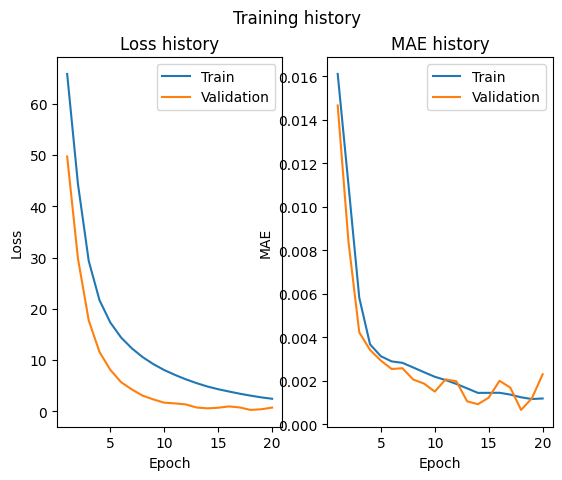

In [36]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.subplot(122)
	plt.title("MAE history")
	plt.plot(absciss, history["train"]["mae"], label="Train")
	plt.plot(absciss, history["val"]["mae"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("MAE")
	plt.legend()
	plt.show()
print_history(history)

In [37]:
model_2 = LSTM(in_dim, hidden_dim, out_dim, sequence_length)
model_2.to(mode["device"])
optimizer = optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_2, 
            loss_function=error_criterion, 
            optimizer=optimizer, 
            data_loader=data_loader, 
            num_epochs=num_epochs, 
            mode=mode
            )



Training the model:

Epoch 1


100%|██████████| 174/174 [00:02<00:00, 65.27it/s]


train loss: 20.85283332015173      train mae: 0.00677205539273671


100%|██████████| 52/52 [00:00<00:00, 193.35it/s]


val loss: 3.4153176248735155      val mae: 0.0038172690777685692

Epoch 2


100%|██████████| 174/174 [00:02<00:00, 74.51it/s]


train loss: 1.5638955958659886      train mae: 0.0017247374324440548


100%|██████████| 52/52 [00:00<00:00, 180.32it/s]


val loss: 0.5530721514831772      val mae: 0.0013579884094787923

Epoch 3


100%|██████████| 174/174 [00:02<00:00, 76.34it/s]


train loss: 0.7269163344809623      train mae: 0.0013067634271298673


100%|██████████| 52/52 [00:00<00:00, 154.90it/s]


val loss: 0.5333115291272296      val mae: 0.0014734186489431895

Epoch 4


100%|██████████| 174/174 [00:02<00:00, 73.43it/s]


train loss: 0.4319073811670638      train mae: 0.0009677714199104937


100%|██████████| 52/52 [00:00<00:00, 149.53it/s]


val loss: 0.16088411752189224      val mae: 0.0006959538608823084

Epoch 5


100%|██████████| 174/174 [00:02<00:00, 75.20it/s]


train loss: 0.2840995233037023      train mae: 0.0007855102457866377


100%|██████████| 52/52 [00:00<00:00, 183.13it/s]


val loss: 0.1333281434848159      val mae: 0.0006201171864739964

Epoch 6


100%|██████████| 174/174 [00:02<00:00, 73.42it/s]


train loss: 0.25211165267594005      train mae: 0.0008543798479969609


100%|██████████| 52/52 [00:00<00:00, 161.47it/s]


val loss: 0.4827100010167571      val mae: 0.0014426400568915128

Epoch 7


100%|██████████| 174/174 [00:02<00:00, 74.87it/s]


train loss: 0.2189156834351655      train mae: 0.0007961525398271058


100%|██████████| 52/52 [00:00<00:00, 184.10it/s]


val loss: 0.12161983194670502      val mae: 0.000894022445187485

Epoch 8


100%|██████████| 174/174 [00:02<00:00, 80.84it/s]


train loss: 0.16505244376024486      train mae: 0.0005902793692047789


100%|██████████| 52/52 [00:00<00:00, 135.04it/s]


val loss: 0.321117762570116      val mae: 0.001464826506410803

Epoch 9


100%|██████████| 174/174 [00:02<00:00, 84.77it/s]


train loss: 0.17042768331976593      train mae: 0.0006834018416399987


100%|██████████| 52/52 [00:00<00:00, 184.20it/s]


val loss: 0.14497534171967916      val mae: 0.0006353309098680202

Epoch 10


100%|██████████| 174/174 [00:02<00:00, 77.89it/s]


train loss: 0.15856114966959348      train mae: 0.0006584775475497514


100%|██████████| 52/52 [00:00<00:00, 163.09it/s]


val loss: 0.09566042726945372      val mae: 0.0007385971627760009

Epoch 11


100%|██████████| 174/174 [00:02<00:00, 75.46it/s]


train loss: 0.16011111337446982      train mae: 0.0006785093308307859


100%|██████████| 52/52 [00:00<00:00, 175.49it/s]


val loss: 0.11178380295138649      val mae: 0.0005419849783862783

Epoch 12


100%|██████████| 174/174 [00:02<00:00, 75.09it/s]


train loss: 0.13918470412745726      train mae: 0.0005565963198405774


100%|██████████| 52/52 [00:00<00:00, 164.21it/s]


val loss: 1.0760138161450712      val mae: 0.002930065085041271

Epoch 13


100%|██████████| 174/174 [00:02<00:00, 73.51it/s]


train loss: 0.17576636159441006      train mae: 0.0006791500793324226


100%|██████████| 52/52 [00:00<00:00, 173.88it/s]


val loss: 0.0908821371859613      val mae: 0.0005269873181152078

Epoch 14


100%|██████████| 174/174 [00:02<00:00, 72.29it/s]


train loss: 0.13255963908938675      train mae: 0.0005323459181166931


100%|██████████| 52/52 [00:00<00:00, 154.81it/s]


val loss: 0.07055845179980716      val mae: 0.0003609344924150646

Epoch 15


100%|██████████| 174/174 [00:02<00:00, 73.67it/s]


train loss: 0.15372600375997778      train mae: 0.0006387581263616861


100%|██████████| 52/52 [00:00<00:00, 169.98it/s]


val loss: 0.08507944914659579      val mae: 0.00058955990018564

Epoch 16


100%|██████████| 174/174 [00:02<00:00, 66.00it/s]


train loss: 0.13007445860254135      train mae: 0.0005227001783375288


100%|██████████| 52/52 [00:00<00:00, 127.75it/s]


val loss: 0.1100536951333659      val mae: 0.0005945922913804479

Epoch 17


100%|██████████| 174/174 [00:02<00:00, 59.91it/s]


train loss: 0.12839018554941925      train mae: 0.0005534801365400945


100%|██████████| 52/52 [00:00<00:00, 148.99it/s]


val loss: 0.11172750966526852      val mae: 0.0008147249364253674

Epoch 18


100%|██████████| 174/174 [00:02<00:00, 68.32it/s]


train loss: 0.1363257361459567      train mae: 0.0005772843397178223


100%|██████████| 52/52 [00:00<00:00, 160.67it/s]


val loss: 0.06534609355890811      val mae: 0.00039360464049256657

Epoch 19


100%|██████████| 174/174 [00:02<00:00, 72.26it/s]


train loss: 0.1301717793271928      train mae: 0.0005619383042152445


100%|██████████| 52/52 [00:00<00:00, 156.72it/s]


val loss: 0.09986089342661676      val mae: 0.0005027150219594108

Epoch 20


100%|██████████| 174/174 [00:02<00:00, 66.72it/s]


train loss: 0.1366083823710933      train mae: 0.0005652879341072353


100%|██████████| 52/52 [00:00<00:00, 151.42it/s]


val loss: 0.0698759403342977      val mae: 0.0003963522601835399


100%|██████████| 23/23 [00:00<00:00, 160.79it/s]


Evaluating the model:
test loss: 0.09671591018232402      test mae: 0.0004434758179894324


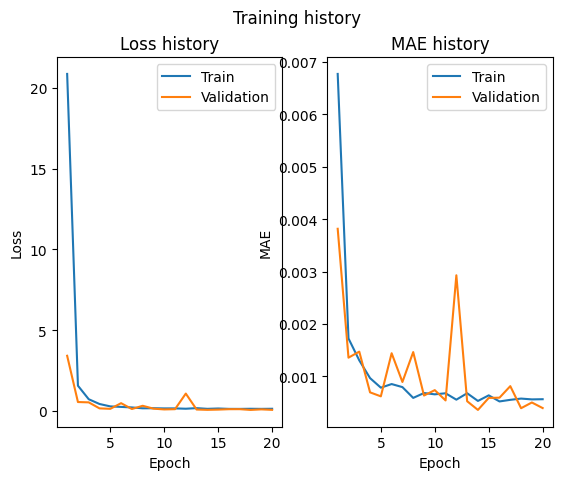

In [38]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.subplot(122)
	plt.title("MAE history")
	plt.plot(absciss, history["train"]["mae"], label="Train")
	plt.plot(absciss, history["val"]["mae"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("MAE")
	plt.legend()
	plt.show()
print_history(history)

In [39]:
model_3 = LSTM(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_3.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_3, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 174/174 [00:02<00:00, 68.79it/s]


train loss: 21.479600567313465      train mae: 0.006904372662515745


100%|██████████| 52/52 [00:00<00:00, 157.40it/s]


val loss: 1.7740133660890662      val mae: 0.0021456668914638225

Epoch 2


100%|██████████| 174/174 [00:02<00:00, 68.51it/s]


train loss: 1.5073151529428706      train mae: 0.0017995411997396248


100%|██████████| 52/52 [00:00<00:00, 150.23it/s]


val loss: 0.34553908638499714      val mae: 0.0007668504470003245

Epoch 3


100%|██████████| 174/174 [00:02<00:00, 71.80it/s]


train loss: 0.6305180860164257      train mae: 0.0011286013573811805


100%|██████████| 52/52 [00:00<00:00, 178.26it/s]


val loss: 1.9274787041628116      val mae: 0.0029962784393784228

Epoch 4


100%|██████████| 174/174 [00:02<00:00, 72.47it/s]


train loss: 0.5493163183924898      train mae: 0.0011709279553816382


100%|██████████| 52/52 [00:00<00:00, 147.76it/s]


val loss: 0.1844472784395658      val mae: 0.0009201950148960135

Epoch 5


100%|██████████| 174/174 [00:02<00:00, 65.63it/s]


train loss: 0.2943191020129693      train mae: 0.000799494299143472


100%|██████████| 52/52 [00:00<00:00, 169.81it/s]


val loss: 0.2985732915432586      val mae: 0.0007994859502144454

Epoch 6


100%|██████████| 174/174 [00:02<00:00, 68.01it/s]


train loss: 0.24578567204654825      train mae: 0.0007845396872327951


100%|██████████| 52/52 [00:00<00:00, 141.52it/s]


val loss: 0.08580828960896641      val mae: 0.0004609472619616175

Epoch 7


100%|██████████| 174/174 [00:03<00:00, 57.32it/s]


train loss: 0.18477417897592496      train mae: 0.0006435668100655908


100%|██████████| 52/52 [00:00<00:00, 128.31it/s]


val loss: 2.435304787366813      val mae: 0.003447991856038503

Epoch 8


100%|██████████| 174/174 [00:02<00:00, 65.54it/s]


train loss: 0.3932289347383591      train mae: 0.0009674472777727646


100%|██████████| 52/52 [00:00<00:00, 117.16it/s]


val loss: 0.08898271388637848      val mae: 0.0005365228314765357

Epoch 9


100%|██████████| 174/174 [00:02<00:00, 60.80it/s]


train loss: 0.15333406103370217      train mae: 0.0005269393413829711


100%|██████████| 52/52 [00:00<00:00, 125.81it/s]


val loss: 0.08818683882691547      val mae: 0.0006450222452909183

Epoch 10


100%|██████████| 174/174 [00:02<00:00, 61.95it/s]


train loss: 0.14757265693496147      train mae: 0.0005642272602966573


100%|██████████| 52/52 [00:00<00:00, 140.99it/s]


val loss: 0.18566153092320065      val mae: 0.0011813996376665822

Epoch 11


100%|██████████| 174/174 [00:02<00:00, 58.19it/s]


train loss: 0.14468825005663632      train mae: 0.0005812398207632777


100%|██████████| 52/52 [00:00<00:00, 121.52it/s]


val loss: 0.07333439312058393      val mae: 0.0003371136658977409

Epoch 12


100%|██████████| 174/174 [00:03<00:00, 56.42it/s]


train loss: 0.13309495621035372      train mae: 0.000505747196444707


100%|██████████| 52/52 [00:00<00:00, 114.28it/s]


val loss: 0.08294441916771214      val mae: 0.0005190197418484016

Epoch 13


100%|██████████| 174/174 [00:02<00:00, 59.21it/s]


train loss: 0.13501965265444563      train mae: 0.0005369983976466336


100%|██████████| 52/52 [00:00<00:00, 131.24it/s]


val loss: 0.1553724471661027      val mae: 0.0011117609014664684

Epoch 14


100%|██████████| 174/174 [00:02<00:00, 62.09it/s]


train loss: 0.14145292736676027      train mae: 0.0006026782761335491


100%|██████████| 52/52 [00:00<00:00, 112.11it/s]


val loss: 0.1698455608093368      val mae: 0.0010227069602933728

Epoch 15


100%|██████████| 174/174 [00:02<00:00, 60.93it/s]


train loss: 0.13215184460128496      train mae: 0.0005452418937022363


100%|██████████| 52/52 [00:00<00:00, 135.93it/s]


val loss: 0.07606242911407843      val mae: 0.0005914606481949769

Epoch 16


100%|██████████| 174/174 [00:02<00:00, 63.87it/s]


train loss: 0.13875389641397412      train mae: 0.0005937786760232186


100%|██████████| 52/52 [00:00<00:00, 102.35it/s]


val loss: 0.06785169857480482      val mae: 0.0004212723189775809

Epoch 17


100%|██████████| 174/174 [00:02<00:00, 63.22it/s]


train loss: 0.13483653258123895      train mae: 0.0005707632010529806


100%|██████████| 52/52 [00:00<00:00, 125.63it/s]


val loss: 0.07236574331742932      val mae: 0.0004599783901764062

Epoch 18


100%|██████████| 174/174 [00:02<00:00, 62.27it/s]


train loss: 0.13589653919683223      train mae: 0.000587598515796585


100%|██████████| 52/52 [00:00<00:00, 112.83it/s]


val loss: 0.08461742250496741      val mae: 0.0003657099610829929

Epoch 19


100%|██████████| 174/174 [00:02<00:00, 60.59it/s]


train loss: 0.1267944267620103      train mae: 0.0005242222219003179


100%|██████████| 52/52 [00:00<00:00, 106.78it/s]


val loss: 0.07336419379842232      val mae: 0.00045366999762946696

Epoch 20


100%|██████████| 174/174 [00:03<00:00, 55.98it/s]


train loss: 0.15671115274984623      train mae: 0.0006961327141020645


100%|██████████| 52/52 [00:00<00:00, 122.80it/s]


val loss: 0.06668203929337568      val mae: 0.0004042125257195069


100%|██████████| 23/23 [00:00<00:00, 116.51it/s]


Evaluating the model:
test loss: 0.09581957732358676      test mae: 0.0004776214233735639


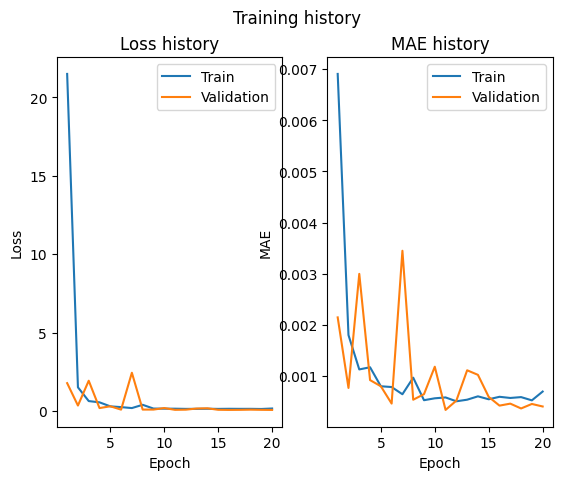

In [40]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.subplot(122)
	plt.title("MAE history")
	plt.plot(absciss, history["train"]["mae"], label="Train")
	plt.plot(absciss, history["val"]["mae"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("MAE")
	plt.legend()
	plt.show()
print_history(history)

In [41]:
def predict(model, loader, model_name):
    preds = []
    ground_truth = []
    model.eval()
    df = pd.DataFrame()
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X.to(mode["device"]))
            preds.append([tensor.item() for tensor in y_pred])
            ground_truth.append([tensor.item() for tensor in y])
    preds = [item for sublist in preds for item in sublist]
    ground_truth = [item for sublist in ground_truth for item in sublist]

    df["pred"] = preds
    df["ground_truth"] = ground_truth
    df.index = data.tail(len(y_test)).index

    mae = mae_sklearn(preds, ground_truth)
    mse = mse_sklearn(preds, ground_truth, squared=True)
    rmse = mse_sklearn(preds, ground_truth, squared=False)

    print(f"Performance measuers with unseen data on {model_name}")
    print("MAE: {:.2f}".format(mae), "MSE: {:.2f}".format(mse), "RMSE: {:.2f}".format(rmse))
    print()

    return df

In [44]:
model_1_history = predict(model_1, test_dataloader, "FCN")
model_2_history = predict(model_2, test_dataloader, "LSTM")
model_3_history = predict(model_3, test_dataloader, "LSTM Attention")

Performance measuers with unseen data on FCN
MAE: 0.63 MSE: 1.86 RMSE: 1.36

Performance measuers with unseen data on LSTM
MAE: 0.11 MSE: 0.10 RMSE: 0.31

Performance measuers with unseen data on LSTM Attention
MAE: 0.12 MSE: 0.10 RMSE: 0.31



In [45]:
import cufflinks as cf
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

model_3_history.iplot()